### Linear Gaussian Model

In [22]:
import numpy as np
from lmfit import Model
from collections import Counter
from math import exp
from math import sqrt
from math import pi
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#### Auxiliary functions

In [2]:
# Skeleton definition
NUI_SKELETON_POSITION_COUNT = 20

NONE = -1
HIP_CENTER = 0
SPINE = 1
SHOULDER_CENTER = 2
HEAD = 3
SHOULDER_LEFT = 4
ELBOW_LEFT = 5
WRIST_LEFT = 6
HAND_LEFT = 7
SHOULDER_RIGHT = 8
ELBOW_RIGHT = 9
WRIST_RIGHT = 10
HAND_RIGHT = 11
HIP_LEFT = 12
KNEE_LEFT = 13
ANKLE_LEFT = 14
FOOT_LEFT = 15
HIP_RIGHT = 16
KNEE_RIGHT = 17
ANKLE_RIGHT = 18
FOOT_RIGHT = 19

nui_skeleton_names = ( \
    'HIP_CENTER', 'SPINE', 'SHOULDER_CENTER', 'HEAD', \
    'SHOULDER_LEFT', 'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', \
    'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT', \
    'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT', 'FOOT_LEFT', \
    'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT' )

nui_skeleton_conn = ( \
    NONE, \
    HIP_CENTER, \
    SPINE, \
    SHOULDER_CENTER, \
    # Left arm 
    SHOULDER_CENTER, \
    SHOULDER_LEFT,  \
    ELBOW_LEFT,  \
    WRIST_LEFT,  \
    # Right arm 
    SHOULDER_CENTER,  \
    SHOULDER_RIGHT,  \
    ELBOW_RIGHT,  \
    WRIST_RIGHT,  \
    # Left leg 
    HIP_CENTER,  \
    HIP_LEFT,  \
    KNEE_LEFT,  \
    ANKLE_LEFT,  \
    # Right leg 
    HIP_CENTER,  \
    HIP_RIGHT,  \
    KNEE_RIGHT,  \
    ANKLE_RIGHT,  \
)


In [3]:
def load_dataset(file=None):
    """
      Returns the data, the labels and the person id for each action
    """
    import scipy.io
    
    if file is None:
        ex = scipy.io.loadmat('data/data.mat')
    else:
        ex = scipy.io.loadmat(file)
        
    return ex['data'],ex['labels'],ex['individuals']


In [4]:
def load_validation(file=None):
    """
      Returns the data, the labels and the person id for each action
    """
    import scipy.io

    if file is None:
        ex = scipy.io.loadmat('data/validation_data.mat')
    else:
        ex = scipy.io.loadmat(file)

    return ex['data_small'], ex['individuals_small'], ex['labels_small'], ex['model_lg'], ex['model_nb'], ex[
        'test_indexes'], ex['train_indexes']


In [5]:
def load_ejemlo(file=None):
    """
      Returns the data, the labels and the person id for each action
    """
    import scipy.io

    if file is None:
        ex = scipy.io.loadmat('data/jobb.mat')
    else:
        ex = scipy.io.loadmat(file)

    return ex['x'], ex['y'], ex['betas'], ex['sigma']

In [6]:
def log_normpdf(x, mu, sigma):
    """
      Computes the natural logarithm of the normal probability density function
      
    """
    exponent = exp(-((x - mu) ** 2 / (2 * sigma ** 2)))
    return np.log((1 / (sqrt(2 * pi) * sigma)) * exponent)


In [7]:
def normalize_logprobs(log_probs):
    """
       Returns the log prob normalizes so that when exponenciated
       it adds up to 1 (Useful to normalizes logprobs)
    """
        #log_probs = log_probs - np.min(log_probs)
    mm = np.max(log_probs)
    #e = 0.001
    return (np.exp(log_probs - mm))
    '''val = log_probs - mm - np.log(np.sum(np.exp(log_probs - mm)))
    val = val + np.abs(np.min(val))
    val = val/np.sum(val)
    return val'''


#### Functions to implement

In [24]:
def fit_gaussian(X, W=None):
    """
      Compute the mean and variance of X, 
      You can ignore W for the moment
    """
    variance = np.std(X)
    mean = np.mean(X)
    return mean, variance


In [15]:
def my_cov(x,y,w):
    """
      Useful function for fit_linear_gaussian
    """
    return np.sum(w*x*y)/np.sum(w)-np.sum(w*x)*np.sum(w*y)/np.sum(w)/np.sum(w)


In [8]:
def fit_linear_gaussian(Y, X, W=None):
    """
    Input:
      Y: vector of size D with the observations for the variable
      X: matrix DxV with the observations for the parent variables
                 of X. V is the number of parent variables
      W: vector of size D with the weights of the instances (ignore for the moment)

    Outout:
       The betas and sigma
    """
    n = X.shape[1]
    A = np.ones([n + 1, n + 1])
    # create matrix A
    for i in range(0, n + 1):
        for j in range(0, n + 1):
            if i == 0 and j != 0:
                A[i, j] = np.mean(X[:, j - 1])
            elif j == 0 and i != 0:
                A[i, j] = np.mean(X[:, i - 1])
            elif i != 0 and j != 0:
                A[i, j] = np.mean(np.multiply(X[:, i - 1], X[:, j - 1]))
    # calculation of b-s
    b = [np.mean(np.multiply(np.transpose(Y), np.squeeze(X[:, i - 1]))) if i != 0 else np.mean(Y) for i in
         range(0, n + 1)]
    # solution with linear algebra
    betas = np.linalg.solve(A, b)

    # finally calculate the sigmas the way we learned in the lecture
    # this is the second part of the equation
    accumulator = 0
    for i in range(0, n):
        for j in range(0, n):
            kovX = np.mean(np.multiply(X[:, j], X[:, i])) - np.mean(X[:, j]) * np.mean(X[:, i])
            accumulator = accumulator + kovX * betas[j + 1] * betas[i + 1]
    # the first part of the equation
    kovY = np.mean(np.multiply(Y, Y)) - (np.mean(Y) * np.mean(Y))
    # and the subtraction
    sigma = sqrt(kovY - accumulator)
    return betas, sigma

In [11]:
# the class which represents our model
class classModel:
    connectivity = None  # n x 2 connectivity matrix, ffirst element is the parent, seond the children
    class_priors = None  # class priors with the initial priors, I set it as equal (but it can be anything else)
    jointparts = []  # where the joins are stored


# the form of a given joint
class jointpart:
    means = None
    sigma = None

    def __init__(self):
        self.sigma = None
        self.means = None
# we give one joint and the funtion find its parent
def find_parents(model, j):
    for k in range(model.connectivity.shape[0]):
        if model.connectivity[k, 1] == j:
            return model.connectivity[k, 0]
    return -1

In [12]:
def learn_model(dataset, labels, G=None):
    """
    Input:
     dataset: The data as it is loaded from load_data
     labels:  The labels as loaded from load_data
     Graph:   (optional) If None, this def should compute the naive
           bayes model. If it contains a skel description (pe
           nui_skeleton_conn, as obtained from skel_model) then it should
           compute the model using the Linear Gausian Model

    Output: the model
     a (tentative) structure for the output model is:
       model.connectivity: the input Graph variable should be stored here
                           for later use.
       model.class_priors: containing a vector with the prior estimations
                           for each class
       model.jointparts[i] contains the estimated parameters for the i-th joint

          For joints that only depend on the class model.jointparts(i) has:
            model.jointparts(i).means: a matrix of 3 x #classes with the
                   estimated means for each of the x,y,z variables of the
                   i-th joint and for each class.
            model.jointparts(i).sigma: a matrix of 3 x #classes with the
                   estimated stadard deviations for each of the x,y,z
                   variables of the i-th joint and for each class.

          For joints that follow a gausian linear model model.jointparts(i) has:
            model.jointparts(i).betas: a matrix of 12 x #classes with the
                   estimated betas for each x,y,z variables (12 in total)
                   of the i-th joint and for each class label.
            model.jointparts(i).sigma: as above

    """
    model = classModel()

    if G is not None:
        #convert the connectivity matrix in a form that is better for us (and which is same as the example
        G = create_connection_matrix(G)
    model.connectivity = G

    # get what kind of classes are, and how many element they have
    tipusok, db = np.unique(labels, return_counts=True)
    numberOfClasses = len(tipusok)

    # define priors by making them equal
    model.class_priors = np.ones(numberOfClasses) * 1 / numberOfClasses

    # separate data for different class
    separated = dict()
    for i in range(numberOfClasses):
        separated[tipusok[i]] = np.zeros([dataset.shape[0], dataset.shape[1], db[i]])
        k = 0
        for j in range(dataset.shape[2]):
            if labels[j] == tipusok[i]:
                separated[tipusok[i]][:, :, k] = dataset[:, :, j]
                k = k + 1

    if G is None:
        model.jointparts = []
        # here we just prepare the model variable by creating the empty sets
        for i in range(dataset.shape[0]):
            darabok = jointpart()
            darabok.means = np.zeros([3, numberOfClasses])
            darabok.sigma = np.zeros([3, numberOfClasses])
            model.jointparts.append(darabok)
        # in this loop we make the training
        for i in range(numberOfClasses):
            for j in range(len(model.jointparts)):
                darab = separated[tipusok[i]]
                # we fit a gaussian to each x,y,z coordinates for each joints for all instances
                # the function will return the parameters of the gaussians
                model.jointparts[j].means[0, i], model.jointparts[j].sigma[0, i] = fit_gaussian(darab[j, 0, :])
                model.jointparts[j].means[1, i], model.jointparts[j].sigma[1, i] = fit_gaussian(darab[j, 1, :])
                model.jointparts[j].means[2, i], model.jointparts[j].sigma[2, i] = fit_gaussian(darab[j, 2, :])
        return model

    else:
        model.jointparts = []
        numberOfParents = 1

        darabok = jointpart()
        darabok.means = np.zeros([3, numberOfClasses])
        darabok.sigma = np.zeros([3, numberOfClasses])
        model.jointparts.append(darabok)
        # initialize the model variable with the empty attributes
        for i in range(1, dataset.shape[0]):
            darabok = jointpart()
            darabok.means = np.zeros([3 * (numberOfParents * 3 + 1), numberOfClasses])
            darabok.sigma = np.zeros([3, numberOfClasses])
            model.jointparts.append(darabok)
        # perform the training
        for i in range(numberOfClasses):
            for j in range(len(model.jointparts)):
                darab = separated[tipusok[i]]  # get the slice of training data for a given class
                parent = find_parents(model, j)  # find the parents of a given joint
                # if it has a parent:
                if parent != -1:
                    parents = np.zeros([dataset.shape[1] * numberOfParents, darab.shape[2]])
                    #Select the data belonging to the parent joint
                    parents[0, :] = darab[parent, 0, :]
                    parents[1, :] = darab[parent, 1, :]
                    parents[2, :] = darab[parent, 2, :]
                    # calculate the betas, and sigma based on the parent for x,y,z
                    x_ek = darab[j, 0, :]  # select the x-es
                    betas, sigma = fit_linear_gaussian(x_ek, np.transpose(parents))
                    model.jointparts[j].means[0:4,
                    i] = betas  # the betas will have 12 row, and 4 will be for x, 4 for y, and 4 for z
                    model.jointparts[j].sigma[0, i] = sigma

                    y_ek = darab[j, 1, :]
                    betas, sigma = fit_linear_gaussian(y_ek, np.transpose(parents))
                    model.jointparts[j].means[4:8, i] = betas
                    model.jointparts[j].sigma[1, i] = sigma

                    z_ek = darab[j, 2, :]
                    betas, sigma = fit_linear_gaussian(z_ek, np.transpose(parents))
                    model.jointparts[j].means[8:12, i] = betas
                    model.jointparts[j].sigma[2, i] = sigma
                else:
                    # if the joint has no parent just create the simple gaussian
                    model.jointparts[j].means[0, i], model.jointparts[j].sigma[0, i] = fit_gaussian(darab[j, 0, :])
                    model.jointparts[j].means[1, i], model.jointparts[j].sigma[1, i] = fit_gaussian(darab[j, 1, :])
                    model.jointparts[j].means[2, i], model.jointparts[j].sigma[2, i] = fit_gaussian(darab[j, 2, :])
        return model

In [13]:
def classify_instances(instances, model):
    """
    Input
       instance: a 20x3x#instances matrix defining body positions of
                 instances
       model: as the output of learn_model

    Output
       probs: a matrix of #instances x #classes with the probability of each
              instance of belonging to each of the classes

    Important: to avoid underflow numerical issues this computations should
               be performed in log space
    """

    numOfClasses = 4
    probs = np.ones([instances.shape[2], numOfClasses])
    # for for each testing instance we
    for i in range(instances.shape[2]):
        probs[i, :] = normalize_logprobs(compute_logprobs(instances[:, :, i], model))
    return probs




In [14]:
def compute_logprobs(example, model):
    """

       Input
           instance: a 20x3 matrix defining body positions of one instance
           model: as given by learn_model

       Output
           l: a vector of len #classes containing the loglikelihhod of the
              instance

    """

    num_of_classes = 4
    if model.connectivity is None:
        l = np.zeros([num_of_classes])
        for k in range(num_of_classes):
            for j in range(len(model.jointparts)):
                x_prob = log_normpdf(example[j, 0], model.jointparts[j].means[0, k], model.jointparts[j].sigma[0, k])
                y_prob = log_normpdf(example[j, 1], model.jointparts[j].means[1, k], model.jointparts[j].sigma[1, k])
                z_prob = log_normpdf(example[j, 2], model.jointparts[j].means[2, k], model.jointparts[j].sigma[2, k])
                log_prior = np.log(model.class_priors[k])
                l[k] = l[k] + (x_prob + y_prob + z_prob + log_prior)
        return l
    else:
        l = np.zeros([num_of_classes])
        for k in range(num_of_classes):
            log_prior = np.log(model.class_priors[k])
            l[k] = log_prior
            for j in range(len(model.jointparts)):
                parent_node = find_parents(model, j)
                if parent_node != -1:
                    for i in range(3):
                        calculation = model.jointparts[j].means[(i * 4), k] \
                                      + (model.jointparts[j].means[(i * 4) + 1, k] * example[parent_node, 0]) \
                                      + (model.jointparts[j].means[(i * 4) + 2, k] * example[parent_node, 1]) \
                                      + (model.jointparts[j].means[(i * 4) + 3, k] * example[parent_node, 2])
                        combined_lognorm = log_normpdf(example[j, i], calculation, model.jointparts[j].sigma[i, k])
                        l[k] = l[k] + combined_lognorm
                else:
                    x_prob = log_normpdf(example[j, 0], model.jointparts[j].means[0, k],
                                         model.jointparts[j].sigma[0, k])
                    y_prob = log_normpdf(example[j, 1], model.jointparts[j].means[1, k],
                                         model.jointparts[j].sigma[1, k])
                    z_prob = log_normpdf(example[j, 2], model.jointparts[j].means[2, k],
                                         model.jointparts[j].sigma[2, k])
                    l[k] = l[k] + (x_prob + y_prob + z_prob)
        return l

In [8]:
def generate_random_lgm_samples(n, betas, sigma):
    """Function to generate random samples for a 
       Linear Gaussian Model
       Input:
           n: Number of samples
           betas: vector with the values the the betas from 0 to k
           sigma: standard deviation
    """
    X = np.random.randn(n,betas.shape[0]-1)
    Y = np.random.randn(n)*sigma + np.sum(X*betas[1:],axis=1)+betas[0]
    return X,Y


In [16]:
def validation(valsegek, labelek):
    tipusok, db = np.unique(labels, return_counts=True)
    szamlalo = 0

    for i in range(valsegek.shape[0]):
        index = np.argmax(valsegek[i, :])
        if tipusok[index] == labelek[i]:
            szamlalo = szamlalo + 1

    print(confusion_matrix(labelek, np.argmax(valsegek, axis=1)))
    confmat = confusion_matrix(labelek, np.argmax(valsegek, axis=1))
    szamlalo = szamlalo / labelek.shape[0]
    print('The accuracy:' + str(szamlalo))

    return szamlalo, confmat


def validation_with_probabilities(valsegek, labelek, fpr, tpr, roc_auc):
    tipusok, db = np.unique(labels, return_counts=True)
    y_scores = np.zeros(labelek.shape)
    szamlalo = 0
    for i in range(valsegek.shape[0]):
        index = np.argmax(valsegek[i, :])
        if tipusok[index] == labelek[i]:
            szamlalo = szamlalo + 1
        y_scores[i] = tipusok[index]


    for i in range(len(tipusok)):
        our_predictions_for_class = np.zeros(labelek.shape[0])
        true_values = np.zeros(labelek.shape[0])
        for j in range(labelek.shape[0]):
            if y_scores[j] == tipusok[i]:
                our_predictions_for_class[j] = valsegek[j, i]
            else:
                our_predictions_for_class[j] = valsegek[j, i]

            if labelek[j] == tipusok[i]:
                true_values[j] = 1
            else:
                true_values[j] = 0

        fpr_local, tpr_local, thresholds = roc_curve(true_values, our_predictions_for_class, pos_label=1)
        fpr[tipusok[i]].append(fpr_local)
        tpr[tipusok[i]].append(tpr_local)
        pyplot.plot(fpr_local, tpr_local, linestyle='-', label= str(tipusok[i]))


        roc_auc_local = auc(fpr_local, tpr_local)
        roc_auc[tipusok[i]].append(roc_auc_local)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    pyplot.legend(loc="lower right")
    pyplot.show()
    print(confusion_matrix(labelek, y_scores))
    confmat = confusion_matrix(labelek, y_scores)
    szamlalo = szamlalo / labelek.shape[0]
    print('The accuracy:' + str(szamlalo))
    return szamlalo, confmat


In [23]:
def create_connection_matrix(G):
    connections = []
    for i in range(len(G)):
        if G[i] is not None:
            temp = connections
            connections_local = np.zeros([1, 2])
            connections_local[0, 0] = int(G[i])
            connections_local[0, 1] = int(i)
            connections.append(connections_local)

    connectivity_matrix = np.zeros([len(connections), 2], dtype=int)
    for i in range(len(connections)):
        connectivity_matrix[i, :] = connections[i]
    return connectivity_matrix


In [17]:
def stratKFoldEval(numberOfDatasets, labels, data, G):
    kf = StratifiedKFold(n_splits=numberOfDatasets)
    accuracy = 0
    conf = np.zeros([4, 4])
    fpr = dict()
    fpr[1] = []
    fpr[2] = []
    fpr[3] = []
    fpr[8] = []
    tpr = dict()
    tpr[1] = []
    tpr[2] = []
    tpr[3] = []
    tpr[8] = []
    roc_auc = dict()
    roc_auc[1] = []
    roc_auc[2] = []
    roc_auc[3] = []
    roc_auc[8] = []
    for train, test in kf.split(labels, labels):
        train_data = data[:, :, train]
        test_data = data[:, :, test]
        train_labels = labels[train]
        test_labels = labels[test]
        bayesianModel = learn_model(train_data, train_labels, G)
        valsegek = classify_instances(test_data, bayesianModel)
        smth, confi = validation_with_probabilities(valsegek, test_labels, fpr, tpr, roc_auc)
        conf = conf + confi
        accuracy = accuracy + smth


    return (accuracy / numberOfDatasets), (conf / numberOfDatasets)


In [18]:
def evaluation(labels, data, G):
    print(stratKFoldEval(5, labels, data, G))
    

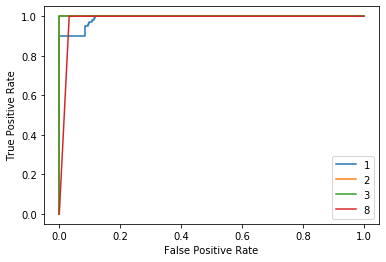

[[ 92   0   0  10]
 [  0 100   0   0]
 [  0   0 105   0]
 [  0   0   0 103]]
The accuracy:0.975609756097561


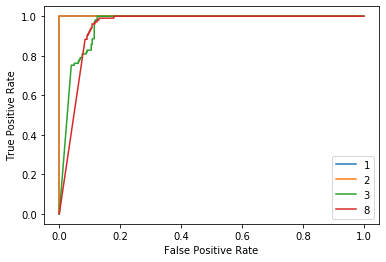

[[102   0   0   0]
 [  0 100   0   0]
 [  0   0  79  26]
 [  0   0  12  91]]
The accuracy:0.9073170731707317


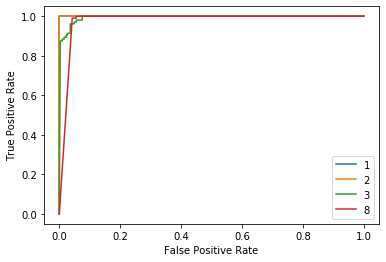

[[102   0   0   0]
 [  0 100   0   0]
 [  0   0  91  13]
 [  0   0   1 102]]
The accuracy:0.9657701711491442


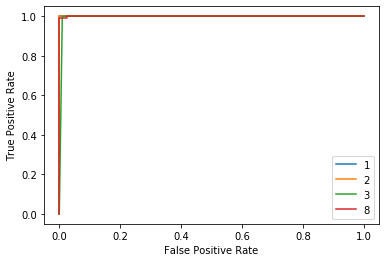

[[101   0   0   0]
 [  0 100   0   0]
 [  0   0 104   0]
 [  0   0   3 100]]
The accuracy:0.9926470588235294


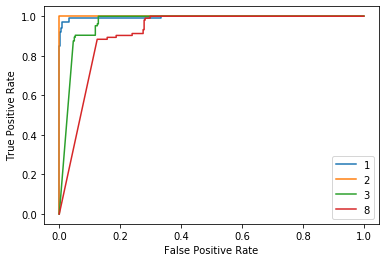

[[75  0  2 24]
 [ 0 99  0  1]
 [ 0  0 91 13]
 [ 0  0 12 91]]
The accuracy:0.8725490196078431
(0.9427786157697617, array([[94.4,  0. ,  0.4,  6.8],
       [ 0. , 99.8,  0. ,  0.2],
       [ 0. ,  0. , 94. , 10.4],
       [ 0. ,  0. ,  5.6, 97.4]]))


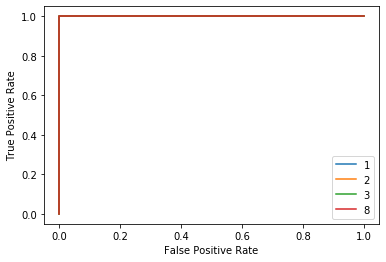

[[102   0   0   0]
 [  0 100   0   0]
 [  0   0 105   0]
 [  0   0   0 103]]
The accuracy:1.0


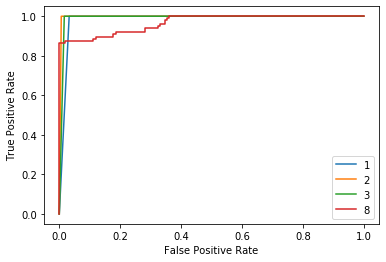

[[102   0   0   0]
 [  0 100   0   0]
 [  0   0 105   0]
 [ 10   2   5  86]]
The accuracy:0.9585365853658536


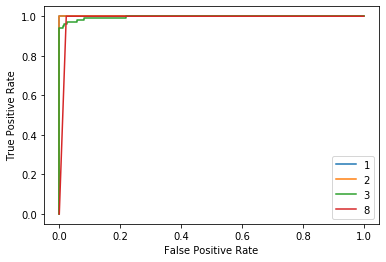

[[102   0   0   0]
 [  0 100   0   0]
 [  0   0  97   7]
 [  0   0   0 103]]
The accuracy:0.9828850855745721


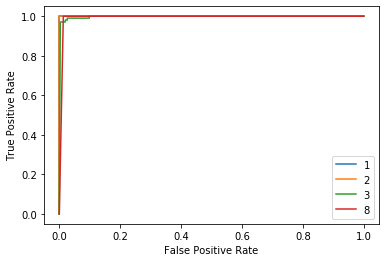

[[101   0   0   0]
 [  0 100   0   0]
 [  0   0 100   4]
 [  0   0   1 102]]
The accuracy:0.9877450980392157


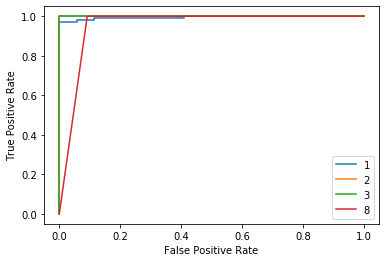

[[ 73   0   0  28]
 [  0 100   0   0]
 [  0   0 104   0]
 [  0   0   0 103]]
The accuracy:0.9313725490196079
(0.9721078635998499, array([[ 96. ,   0. ,   0. ,   5.6],
       [  0. , 100. ,   0. ,   0. ],
       [  0. ,   0. , 102.2,   2.2],
       [  2. ,   0.4,   1.2,  99.4]]))


'data_small, individuals_small, labels_small, model_lg, model_nb, test_indexes, train_indexes =load_validation()\n\nbayesianModel = learn_model(data, labels)\n\nvalsegek = classify_instances(data_small, bayesianModel)\n#valsegek = classify_instances(data, bayesianModel)\nvalidation(valsegek, labels)'

In [25]:
data, labels, individuals = load_dataset()
#Naive Bayes
evaluation(labels, data, None)
#With connections
evaluation(labels, data, nui_skeleton_conn)


'''data_small, individuals_small, labels_small, model_lg, model_nb, test_indexes, train_indexes =load_validation()

bayesianModel = learn_model(data, labels)

valsegek = classify_instances(data_small, bayesianModel)
#valsegek = classify_instances(data, bayesianModel)
validation(valsegek, labels)'''
